# Data Loading

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, preprocessing 
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from google.colab import files

In [9]:
train_df= pd.read_csv("/content/drive/MyDrive/DEBI/nlp/Group_project/final_project/Dataset/train.csv")
test_df= pd.read_csv("/content/drive/MyDrive/DEBI/nlp/Group_project/final_project/Dataset/test.csv")
test_labels_df= pd.read_csv("/content/drive/MyDrive/DEBI/nlp/Group_project/final_project/Dataset/sample_submission.csv")

In [10]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [12]:
test_labels_df.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


# Functions

In [13]:
def clean_text(text,stop_words=True):
  ## 1. Lowercase the text
  text = text.lower() 

  ## 2. Remove Punctuations
  text = text.translate(str.maketrans('', '', string.punctuation)) 
  
  ## 3. Tokenize all the words
  words = nltk.word_tokenize(text)

  ## 4. Remove stopwords and word digits
  #clean_text = " ".join([ w for w in words if w.isalnum() ])
  if stop_words==False:
    clean_text = " ".join([ w for w in words if w.isalnum()])
  else:
    stop_words = set(stopwords.words('english'))
    stop_words = set(stop_words) - set(['who', 'when', 'why','where','which','whom','how','what'])
    clean_text = " ".join([ w for w in words if w.isalnum() and (w not in stop_words)  ])
    
  clean_text = clean_text.replace("\t", ' ')
  
  return clean_text

In [14]:
##getting length of each question
def ques_len(train_df):
  q=train_df.split(" ")
  return len(q)

# Data Exploration

In [15]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


**Checking for null values**

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Reviewing the number of records in each column, there are some questions that have null values

In [17]:
np.where(pd.isnull(train_df['question2']))

(array([105780, 201841]),)

In [18]:
np.where(pd.isnull(train_df['question1']))

(array([363362]),)

In [19]:
train_df.iloc[105780,:]

id                                      105780
qid1                                    174363
qid2                                    174364
question1       How can I develop android app?
question2                                  NaN
is_duplicate                                 0
Name: 105780, dtype: object

In [20]:
train_df.iloc[201841,:]

id                                        201841
qid1                                      303951
qid2                                      174364
question1       How can I create an Android app?
question2                                    NaN
is_duplicate                                   0
Name: 201841, dtype: object

In [21]:
train_df.iloc[363362,:]

id                                                         363362
qid1                                                       493340
qid2                                                       493341
question1                                                     NaN
question2       My Chinese name is Haichao Yu. What English na...
is_duplicate                                                    0
Name: 363362, dtype: object

**Checking the number of unique question in the Dataset**

In [22]:
print("Number of unique Questions in Column 1 :")
q1_unique=train_df['question1'].nunique()
q1_unique

Number of unique Questions in Column 1 :


290456

In [23]:
print("Number of unique Questions in Column 2 :")
q2_unique=train_df['question2'].nunique()
q2_unique

Number of unique Questions in Column 2 :


299174

In [24]:
print("Number of unique Questions in All the dataset :")
all_questions= pd.concat([train_df['question1'] , train_df['question2']],axis=0, ignore_index=True)
all_unique=all_questions.nunique()
all_unique

Number of unique Questions in All the dataset :


537360

In [25]:
train_df.shape[0]

404290

Percentage of unique Questions:  66.46


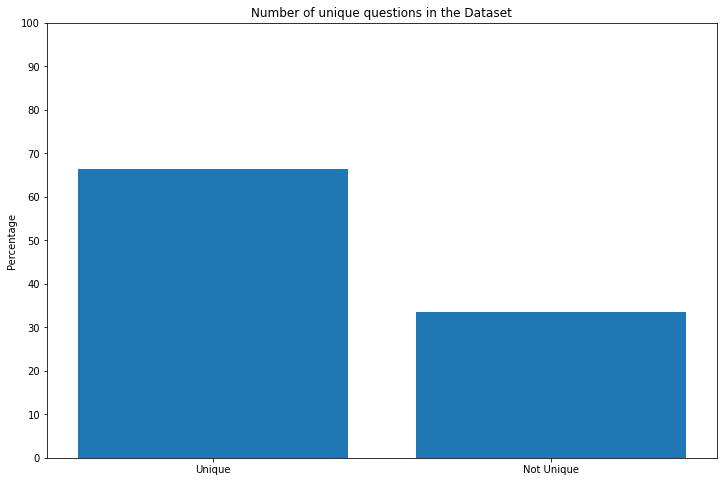

In [26]:
###Bar plot for the number of unique questions in the dataset 

##Calculating Percentages
uniq_per=(all_unique/all_questions.shape[0])*100
not_per=((all_questions.shape[0]-all_unique)/all_questions.shape[0])*100
print("Percentage of unique Questions: ",np.round(uniq_per,2))

###Bar plot
fig = plt.subplots(figsize =(12, 8));
plt.bar(["Unique","Not Unique"], [uniq_per,not_per]);
plt.title("Number of unique questions in the Dataset");
plt.ylabel("Percentage");
plt.yticks(np.arange(0,110,10));

We can see that the number of unique questions in the dataset is about **66**% of the dataset and the rest is just a repeated questions

**Checking the labels Precentages**

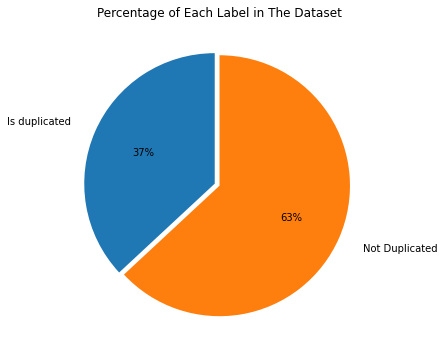

In [27]:
##plotting a pie chart for the labels

##Calculating Percentages
label_1 = (((train_df['is_duplicate']==1).sum())/train_df.shape[0])*100
label_2 = ((train_df['is_duplicate']==0).sum()/train_df.shape[0])*100


##Pie Chart
fig = plt.subplots(figsize =(10, 6));
plt.pie([label_1,label_2],labels=["Is duplicated", "Not Duplicated"],startangle=90,autopct='%1.0f%%', labeldistance=1.2,explode=[0.04,0]);
plt.title("Percentage of Each Label in The Dataset");


**More of Exploration on the labeling Technique**

In [28]:
##Checking if there is a cases where q1= q2
df_temp=train_df[train_df.question1==train_df.question2]
print(df_temp.shape)
print(df_temp['is_duplicate'].shape)

(0, 6)
(0,)


In [29]:
df_temp

,id,qid1,qid2,question1,question2,is_duplicate


In [30]:
##Cleaning Text
##Removing Rows with NaN questions
df_temp2=train_df.drop(index= [201841,105780,363362])
df_temp2['question1']=[clean_text(x) for x in df_temp2['question1']]
df_temp2['question2']=[clean_text(x) for x in df_temp2['question2']]

In [31]:
##Checking if there is a cases where q1= q2 after cleaning
df_temp2=df_temp2[df_temp2.question1==df_temp2.question2]
print(df_temp2.shape)
print(df_temp2[df_temp2['is_duplicate']==0].shape)
df_temp2[df_temp2['is_duplicate']==0]

(11295, 6)
(1979, 6)


,id,qid1,qid2,question1,question2,is_duplicate
41,41,83,84,when expect cognizant confirmation mail,when expect cognizant confirmation mail,0
222,222,445,446,how find job japan,how find job japan,0
277,277,554,555,how people die,how people die,0
298,298,596,597,what online platforms post ads beer money oppo...,what online platforms post ads beer money oppo...,0
303,303,606,607,exist,exist,0
...,...,...,...,...,...,...
403848,403848,537464,95350,how come know love,how come know love,0
403876,403876,174864,72923,how solve equation,how solve equation,0
403991,403991,537611,537612,why vote modi,why vote modi,0
404160,404160,314605,8991,how happy,how happy,0


From the above results, we can see that after the cleaning process, there are 16368 records that have Q1=Q2 and there are 3748 of them are labeled as different questions, so we need more exploration of these questions

In [32]:
##looking deeper into these questions
train_df.iloc[41,:]

id                                                             41
qid1                                                           83
qid2                                                           84
question1       When can I expect my Cognizant confirmation mail?
question2          When can I expect Cognizant confirmation mail?
is_duplicate                                                    0
Name: 41, dtype: object

In [33]:
train_df.iloc[111,:].head()

id                                                         111
qid1                                                       223
qid2                                                       224
question1       Is USA the most powerful country of the world?
question2    Why is the USA the most powerful country of th...
Name: 111, dtype: object

In [34]:
train_df.iloc[222,:]

id                                             222
qid1                                           445
qid2                                           446
question1             How can I find job in Japan?
question2       How can I find an IT job in Japan?
is_duplicate                                     0
Name: 222, dtype: object

In [35]:
train_df.iloc[277,:]

id                                  277
qid1                                554
qid2                                555
question1       How do most people die?
question2            How do people die?
is_duplicate                          0
Name: 277, dtype: object

In [36]:
##Taking a look into the real questions before cleaning
train_df.iloc[df_temp2[df_temp2['is_duplicate']==0].index,:]

,id,qid1,qid2,question1,question2,is_duplicate
41,41,83,84,When can I expect my Cognizant confirmation mail?,When can I expect Cognizant confirmation mail?,0
222,222,445,446,How can I find job in Japan?,How can I find an IT job in Japan?,0
277,277,554,555,How do most people die?,How do people die?,0
298,298,596,597,On what online platforms can I post ads for be...,What online platforms can I post ads for beer ...,0
303,303,606,607,Do I exist?,Do we exist?,0
...,...,...,...,...,...,...
403848,403848,537464,95350,How do you come to know that you love her or not?,How will you come to know that you are in love?,0
403876,403876,174864,72923,How do I solve the equation?,How do I solve this equation?,0
403991,403991,537611,537612,Why should I not vote for Modi?,Why did you vote for Modi?,0
404160,404160,314605,8991,How can you not be happy?,How can I be happy?,0


**Checking the length of each question**

In [37]:
##getting length of each question
##Dropping empty rows first
df_temp3=train_df.drop(index= [201841,105780,363362])

df_temp3['quest1_len']=df_temp3['question1'].apply(ques_len)
df_temp3['quest2_len']=df_temp3['question2'].apply(ques_len)

In [38]:
(df_temp3['quest1_len'] < 2).sum()

66

In [39]:
df_temp3[df_temp3['quest1_len'] < 2]

,id,qid1,qid2,question1,question2,is_duplicate,quest1_len,quest2_len
3306,3306,6553,6554,.,Why is Cornell's endowment the lowest in the I...,0,1,10
13016,13016,25026,25027,?,Why should one not work at Google?,0,1,7
17682,17682,33561,33562,deleted,Which website will be suitable for downloading...,0,1,10
20794,20794,39204,39205,?,What is the Gmail tech support help phone number?,0,1,9
23305,23305,33561,43661,deleted,Which are some best websites for downloading n...,0,1,10
...,...,...,...,...,...,...,...,...
356434,356434,147899,485756,Deleted.,Do gay men find red headed men more attractive...,0,1,15
357127,357127,486520,146954,H,Should I forgive the cheater?,0,1,5
365317,365317,33561,365465,deleted,From which site I can download GTA 4 game?,0,1,9
381124,381124,512812,512813,no,I have a BS and MPH and hate my job. I found t...,0,1,27


In [40]:
(df_temp3['quest2_len'] < 2).sum()

22

In [41]:
df_temp3[df_temp3['quest2_len'] < 2]

,id,qid1,qid2,question1,question2,is_duplicate,quest1_len,quest2_len
20072,20072,37898,37899,How could I solve this?,…………..,0,5,1
46596,46596,83328,83329,How To Edit DNA?,What?,0,4,1
47056,47056,84067,84068,Is there anywhere in the world offering pain m...,?,0,19,1
51909,51909,92003,83329,What should yellow taxis do to face competitio...,What?,0,12,1
74304,74304,127360,127361,Is there any chances for hailstones tomorrow?,parisflatlist,0,7,1
109009,109009,178981,178982,How do I make a box that I can put my phone in...,Hh,0,25,1
130637,130637,209606,209607,Does the Quran surah 23: 5-6 prove that Allah ...,Does?,0,16,1
144506,144506,228687,228688,How beautiful do you think you are?,Delete,0,7,1
145000,145000,229359,229360,Me and my girlfriend wish to go out and do 'st...,Deleted.,0,28,1
175282,175282,269923,44699,Hh,HH,1,2,1


**There are multiple questions that there length is less than 3 words, thoses must be meaningless sentences**

# Data & Text cleaning

In [42]:
##Removing Rows with NaN questions
train_df.drop(index= [201841,105780,363362],inplace=True)

In [43]:
##Getting length of each question
train_df['quest1_len']=train_df['question1'].apply(ques_len)
train_df['quest2_len']=train_df['question2'].apply(ques_len)

In [44]:
###Removing Rows with question length is less than 2
train_df=train_df[train_df['quest1_len'] >1 ]

In [45]:
###Removing Rows with question length is less than 2
train_df=train_df[train_df['quest2_len'] >1 ]

In [46]:
##Cleaning Text
train_df['question1']=train_df['question1'].apply(clean_text,stop_words=False)
train_df['question2']=train_df['question2'].apply(clean_text,stop_words=False)

In [47]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,quest1_len,quest2_len
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,14,12
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0,8,13
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,14,10
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0,11,9
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,13,7


**Saving Cleaned Version of the Dataset**

In [48]:
train_df.to_csv('training_data_cleaned.csv', index=False) 

In [49]:
##Cleaning Text
train_df['question1']=train_df['question1'].apply(clean_text,stop_words=True)
train_df['question2']=train_df['question2'].apply(clean_text,stop_words=True)

In [50]:
train_df.to_csv('training_data_without_stop_words.csv', index=False) 